In [1]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Loading the images as tensorflow datasets

We load images in to tensorflow data sets with the function:
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

Labels are inferred from the subfolders in 'train', we let label_mode be 'int', so the classes will be enconded as integers and thus denoted with 0,1,2... depending on the breed the image belongs too. This is suitable for a loss function such as: sparse_categorical_crossentropy.

We need to specify the image size since all images need to have same size. The images in the folder have size (224,224).

We let validation_split=0.2 so we can reserve some 20% of the images for validation. Remember we have a test folder for making the final predictions, and we can use the validation to tweak or parameters.

In [2]:
# Get Train Data Set
train_ds = keras.preprocessing.image_dataset_from_directory(
            'cropped/train', labels='inferred', label_mode='int',
            class_names=None, color_mode='rgb', batch_size=32, image_size=(224,224), 
            shuffle=True, seed=1, validation_split=0.2, subset='training')

# Get Validation Data Set
val_ds = keras.preprocessing.image_dataset_from_directory(
            'cropped/train', labels='inferred', label_mode='int',
            class_names=None, color_mode='rgb', batch_size=32, image_size=(224,224), 
            shuffle=True, seed=1, validation_split=0.2, subset='validation')

# Get Train Data Set
test_ds = keras.preprocessing.image_dataset_from_directory(
            'cropped/test', labels='inferred', label_mode='int',
            class_names=None, color_mode='rgb', batch_size=32, image_size=(224,224), 
            shuffle=True, seed=1, validation_split=0)

Found 12000 files belonging to 120 classes.
Using 9600 files for training.
Found 12000 files belonging to 120 classes.
Using 2400 files for validation.
Found 8580 files belonging to 120 classes.


In [3]:
# The class names are annoying but fine for now
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

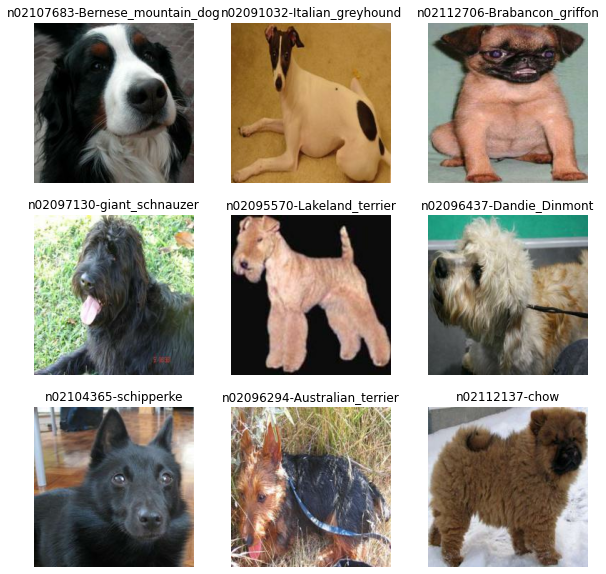

In [4]:
# Lets see some of the input images
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


The image_batch is a tensor of the shape (32, 224, 224, 3). This is a batch of 32 images of shape 224x224x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# Preprocessing images (data augmentation)

We first of all need to rescale the images so values lie between 0 and 1 instead of 0 and 255 which is standard for RGB images. This is because smaller numbers are better for the neural network. We can perform some data augmentation as well which tries to reduce overfitting. For this case it means that we will flip images and rotate images randomly so the deep learning can also appreciate dogs upside down or with their head tilted. There are two ways we can do this:
1) As part of the model. With this option, your data augmentation will happen on device, synchronously with the rest of the model execution, meaning that it will benefit from GPU acceleration. When you export your model using model.save, the preprocessing layers will be saved along with the rest of your model. If you later deploy this model, it will automatically standardize images (according to the configuration of your layers). This can save you from the effort of having to reimplement that logic server-side. <br> <br>
2) Data augmentation will happen asynchronously on the CPU, and is non-blocking. You can overlap the training of your model on the GPU with data preprocessing, using Dataset.prefetch, shown below. In this case the prepreprocessing layers will not be exported with the model when you call model.save. You will need to attach them to your model before saving it or reimplement them server-side. After training, you can attach the preprocessing layers before export.

For now I am running it on my computer using CPU and we will therefor go with option number two. We use the example in: https://www.tensorflow.org/tutorials/images/data_augmentation

In [6]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

rescale = keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
data_augmentation = tf.keras.Sequential([
                    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                    layers.experimental.preprocessing.RandomRotation(0.2),])

def prepare(ds, shuffle=False, augment=False):
    
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)
    
    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
# Lets rescale all images, but only augment the training data
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# Stealing a model

In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/5
300/300 [==============================] - 290s 858ms/step - loss: 4.8093 - accuracy: 0.0128 - val_loss: 4.6091 - val_accuracy: 0.0221
Epoch 2/5
300/300 [==============================] - 268s 813ms/step - loss: 4.4925 - accuracy: 0.0285 - val_loss: 4.3762 - val_accuracy: 0.0325
Epoch 3/5
287/300 [===========================>..] - ETA: 10s - loss: 4.3136 - accuracy: 0.0344

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()